<a href="https://colab.research.google.com/github/daysm/id2223/blob/master/lab2/lab2_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Based on *Image captioning with visual attention* [TensorFlow tutorial](https://www.tensorflow.org/tutorials/text/image_captioning)

[APACHE LICENSE, VERSION 2.0](https://www.apache.org/licenses/LICENSE-2.0)


Given an image like the example below, our goal is to generate a caption such as "a surfer riding on a wave".

![Man Surfing](https://tensorflow.org/images/surf.jpg)

[Image Source](https://commons.wikimedia.org/wiki/Surfing#/media/File:Surfing_in_Hawaii.jpg)

We train a model on 30,000 captions for about 20,000 images (because there are multiple captions per image in the dataset).

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

import matplotlib.pyplot as plt

# Scikit-learn includes many helpful utilities
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

# import re
import numpy as np
import os
import time
import json
from glob import glob
from PIL import Image
import pickle

TensorFlow 2.x selected.


In [2]:
!pip install wandb -q

     |████████████████████████████████| 1.4MB 2.7MB/s 
     |████████████████████████████████| 102kB 8.6MB/s 
     |████████████████████████████████| 92kB 7.4MB/s 
     |████████████████████████████████| 256kB 17.0MB/s 
     |████████████████████████████████| 92kB 6.9MB/s 
     |████████████████████████████████| 460kB 17.1MB/s 
     |████████████████████████████████| 184kB 20.2MB/s 
     |████████████████████████████████| 71kB 8.9MB/s 


In [0]:
import wandb

In [4]:
wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [5]:
wandb.init(entity="daysm", project="id2223-lab2-2")

W&B Run: https://app.wandb.ai/daysm/id2223-lab2-2/runs/lo6u7t8u

Skip if only limited dataset needed
## Download and prepare the MS-COCO dataset

You will use the [MS-COCO dataset](http://cocodataset.org/#home) to train our model. The dataset contains over 82,000 images, each of which has at least 5 different caption annotations. The code below downloads and extracts the dataset automatically.

**Caution: large download ahead**. You'll use the training set, which is a 13GB file.

In [6]:
sub_dir = "."
annotation_zip = tf.keras.utils.get_file('annotations.zip',
                                          cache_subdir=os.path.abspath(sub_dir),
                                          origin = 'http://images.cocodataset.org/annotations/annotations_trainval2014.zip',
                                          extract = True)
annotation_file = os.path.dirname(annotation_zip)+'/annotations/captions_train2014.json'

name_of_zip = 'train2014.zip'
if not os.path.exists(os.path.abspath(sub_dir) + '/' + name_of_zip):
  image_zip = tf.keras.utils.get_file(name_of_zip,
                                      cache_subdir=os.path.abspath(sub_dir),
                                      origin = 'http://images.cocodataset.org/zips/train2014.zip',
                                      extract = True)
  PATH = os.path.dirname(image_zip)+'/train2014/'
else:
  PATH = os.path.abspath(sub_dir)+'/train2014/'

13510574080/13510573713 [==============================] - 802s 0us/step


## Optional: limit the size of the training set 
To speed up training for this tutorial, you'll use a subset of 30,000 captions and their corresponding images to train our model. Choosing to use more data would result in improved captioning quality.

In [0]:
# Read the json file
with open(annotation_file, 'r') as f:
    annotations = json.load(f)

# Store captions and image names in vectors
all_captions = []
all_image_names = []

for annot in annotations['annotations']:
    caption = '<start> ' + annot['caption'] + ' <end>'
    image_id = annot['image_id']
    full_coco_image_path = PATH + 'COCO_train2014_' + '%012d.jpg' % (image_id)

    all_image_names.append(full_coco_image_path)
    all_captions.append(caption)

# Shuffle captions and image_names together
# Set a random state
captions, image_names = shuffle(all_captions,
                                          all_image_names,
                                          random_state=1)

# Select the first num_examples captions from the shuffled set
num_examples = 30000
captions = captions[:num_examples]
image_names = image_names[:num_examples]

In [8]:
len(captions), len(all_captions)

(30000, 414113)

## Start from here for limited dataset

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
!cp -r /content/drive/My\ Drive/Datasets/image_names.p .
!cp -r /content/drive/My\ Drive/Datasets/captions.p .

In [0]:
!unzip -qq /content/drive/My\ Drive/Datasets/images-20191228T225554Z-001.zip

replace images/COCO_train2014_000000082048.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [0]:
with open('captions.p', 'rb') as f:
  captions = pickle.load(f)

In [0]:
with open('image_names.p', 'rb') as f:
  image_names = pickle.load(f)

## Preprocess the images using InceptionResNetV2
We first convert the images into InceptionResNetV2's expected format by:
* Resizing the image to 299x299
* [Preprocessing](https://cloud.google.com/tpu/docs/inception-v3-advanced#preprocessing_stage) the image (to normalize the image so that it contains pixels in the range of -1 to 1, which matches the format of the images used to train InceptionResNetV2) using [preprocess_input](https://www.tensorflow.org/api_docs/python/tf/keras/applications/inception_resnet_v2/preprocess_input).

In [0]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_resnet_v2.preprocess_input(img)
    return img, image_path

## Initialize InceptionResNetV2

We will use InceptionResNetV2 with pretrained Imagenet weights to extract features from the images by saving the output from the last convolutional layer.
The shape of the output of that last convolutional layer is `8x8x1536`.

In [10]:
image_features_extract_model = tf.keras.applications.inception_resnet_v2.InceptionResNetV2(include_top=False, weights='imagenet')

219062272/219055592 [==============================] - 18s 0us/step


## Extract and cache features

In [11]:
from tqdm import tqdm
# Get unique images
encode_train = sorted(set(image_names))

# Feel free to change batch_size according to your system configuration
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(16)

for batch_images, batch_paths in tqdm(image_dataset):
  batch_features = image_features_extract_model(batch_images)
  batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))

  for image_features, p in zip(batch_features, batch_paths):
    path_of_feature = p.numpy().decode("utf-8")

    # .npy is appended to path
    np.save(path_of_feature, image_features.numpy())

1622it [14:24,  1.80it/s]


## Preprocess and tokenize captions

* Tokenize the captions
* Limit the vocabulary size to the top 5,000 words (to save memory). Replace other words with <unk>.
* Create word-to-index and index-to-word mappings.
* Pad sequences (with 0) to be the same length as the longest one.

In [0]:
# Find maximum length of any caption in dataset
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

In [0]:
top_k = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(captions)
caption_seqs = tokenizer.texts_to_sequences(captions)

# pad value == 0
# Max_length value not provided, hence automatically calculated
# shape == (len(train_seqs), calc_max_length(train_seqs))
captions_tokenized = tf.keras.preprocessing.sequence.pad_sequences(caption_seqs, padding='post')

# Update indices to include token for padding
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

max_length = calc_max_length(caption_seqs)

## Split the data into training and testing

In [0]:
# Create training and validation sets using an 80-20 split
image_names_train, image_names_val, captions_train, captions_val = train_test_split(image_names,
                                                                    captions_tokenized,
                                                                    test_size=0.2,
                                                                    random_state=0)

In [15]:
len(image_names_train), len(captions_train), len(image_names_val), len(captions_val)

(24000, 24000, 6000, 6000)

## Create a tf.data dataset for training



 Our images and captions are ready! Next, let's create a tf.data dataset to use for training our model.

In [0]:
# Number of training instances in batch
BATCH_SIZE = 32

# Number of elements from which to sample when shuffling
# More info here: https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shuffle
BUFFER_SIZE = 1000

In [0]:
# Load the numpy files
def map_func(img_name, cap):
  image_features = np.load(img_name.decode('utf-8')+'.npy')
  return image_features, cap

In [0]:
dataset = tf.data.Dataset.from_tensor_slices((image_names_train, captions_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Shuffle and batch
# The elements of the dataset are now batches
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# Create new dataset that prefetches elements.
# buffer_size determines how many elements (in our case batches)
# are prefetched. Setting buffer_size=tf.data.experimental.AUTOTUNE
# makes the tf.data runtime tune the value dynamically.
# More here: https://www.tensorflow.org/guide/data_performance
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

## Model
The model architecture is inspired by the [Show and Tell](https://arxiv.org/abs/1411.4555) paper.

* The encoder encodes the image (or rather the already extracted features). The encoder is (a single fully connected layer). This creates an encoding of size `embedding_dim`.
* The decoder receives the encoded image and the start token <start> and generates the caption 

In [0]:
# Dimension of representation (output of encoder, input of decoder)
embedding_dim = 256

# Dimension of hidden state of RNN
units = 512


vocab_size = len(tokenizer.word_index) + 1  # why + 1?
num_steps = len(image_names_train) // BATCH_SIZE

In [0]:
class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it using pickle
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim, activation='relu')

    def call(self, x):
        x = self.fc(x)
        return x

In [0]:
class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

  def call(self, caption_token, image_features, hidden):
    # shape == (batch_size, 1, embedding_dim)
    x = self.embedding(caption_token)

    image_features = tf.reduce_sum(image_features, axis=1)
    image_features = tf.expand_dims(image_features, 1)
    x = tf.concat([image_features, x], axis=-1)
    
    output, state = self.gru(x)

    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)

    # shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # shape == (batch_size * max_length, vocab)
    x = self.fc2(x)

    return x, state #, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

In [0]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

In [0]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

## Checkpoint

In [0]:
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [0]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])

## Training


In [0]:
loss_plot = []

In [0]:
@tf.function
def train_step(image_features, target):
  loss = 0

  # Initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])

  # shape: (BATCH_SIZE, 1)
  # Index of start token ("<start>") for each sample in batch
  caption_token = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

  with tf.GradientTape() as tape:
      encoded_image = encoder(image_features)
      for i in range(1, target.shape[1]):
          predictions, hidden = decoder(caption_token, encoded_image, hidden)
          loss += loss_function(target[:, i], predictions)

          # using teacher forcing
          dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))
  trainable_variables = encoder.trainable_variables + decoder.trainable_variables
  gradients = tape.gradient(loss, trainable_variables)
  optimizer.apply_gradients(zip(gradients, trainable_variables))
  return loss, total_loss

In [28]:
EPOCHS = 20

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (image_features, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(image_features, target)
        total_loss += t_loss

        if batch % 100 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(
              epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))

    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)
    wandb.log({'loss': loss_plot[-1].numpy()})

    if epoch % 5 == 0:
      ckpt_manager.save()

    print ('Epoch {} Loss {:.6f}'.format(epoch + 1, total_loss/num_steps))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 2.2588
Epoch 1 Batch 100 Loss 1.2439
Epoch 1 Batch 200 Loss 1.2904
Epoch 1 Batch 300 Loss 1.3439
Epoch 1 Batch 400 Loss 1.3864
Epoch 1 Batch 500 Loss 1.1366
Epoch 1 Batch 600 Loss 1.2665
Epoch 1 Batch 700 Loss 1.2409
Epoch 1 Loss 1.274317
Time taken for 1 epoch 290.84635758399963 sec

Epoch 2 Batch 0 Loss 1.1690
Epoch 2 Batch 100 Loss 1.2908
Epoch 2 Batch 200 Loss 1.2560
Epoch 2 Batch 300 Loss 1.2145
Epoch 2 Batch 400 Loss 1.1495
Epoch 2 Batch 500 Loss 1.1002
Epoch 2 Batch 600 Loss 1.2620
Epoch 2 Batch 700 Loss 1.2283
Epoch 2 Loss 1.217555
Time taken for 1 epoch 251.6740701198578 sec

Epoch 3 Batch 0 Loss 1.1453
Epoch 3 Batch 100 Loss 1.2173
Epoch 3 Batch 200 Loss 1.1791
Epoch 3 Batch 300 Loss 1.1225
Epoch 3 Batch 400 Loss 1.1588
Epoch 3 Batch 500 Loss 1.1305
Epoch 3 Batch 600 Loss 1.2435
Epoch 3 Batch 700 Loss 1.1849
Epoch 3 Loss 1.180926
Time taken for 1 epoch 250.58922147750854 sec

Epoch 4 Batch 0 Loss 1.0380
Epoch 4 Batch 100 Loss 1.1492
Epoch 4 Batch 200 Loss

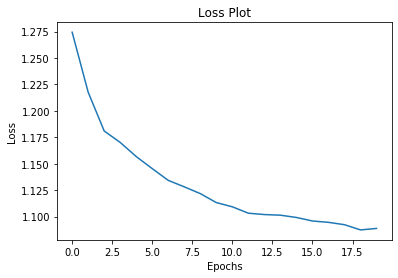

In [29]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

View run on [WandB](https://app.wandb.ai/daysm/id2223-lab2-2/runs/lo6u7t8u)

## Caption

* The evaluate function is similar to the training loop, except you don't use teacher forcing here. The input to the decoder at each time step is its previous predictions along with the hidden state and the encoder output.
* Stop predicting when the model predicts the end token.
* And store the attention weights for every time step.

In [0]:
def caption(image):
    hidden = decoder.reset_state(batch_size=1)

    # Create a batch with one image
    one_image_batch = tf.expand_dims(load_image(image)[0], 0)

    # Extract image features
    image_features = image_features_extract_model(one_image_batch)
    image_features = tf.reshape(image_features, (image_features.shape[0], -1, image_features.shape[3]))

    # Encode image
    features = encoder(image_features)

    # Initial decoder input token
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)

    result = []

    # Stop decoding at max_length or when <end> is emitted
    for i in range(max_length):
        predictions, hidden = decoder(dec_input, features, hidden)
        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])
        if tokenizer.index_word[predicted_id] == '<end>':
            return result
        dec_input = tf.expand_dims([predicted_id], 0)
    return result

In [58]:
# captions on the validation set
rid = np.random.randint(0, len(image_names_val))
image = image_names_val[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in captions_val[rid] if i not in [0]])
result = caption(image)

print ('Real caption:', real_caption)
print ('Predicted caption:', ' '.join(result))

Real caption: <start> a big slice of pizza sitting on a plate <end>
Predicted caption: pizza the and in paste cheese on serving sliced face counter on <end>


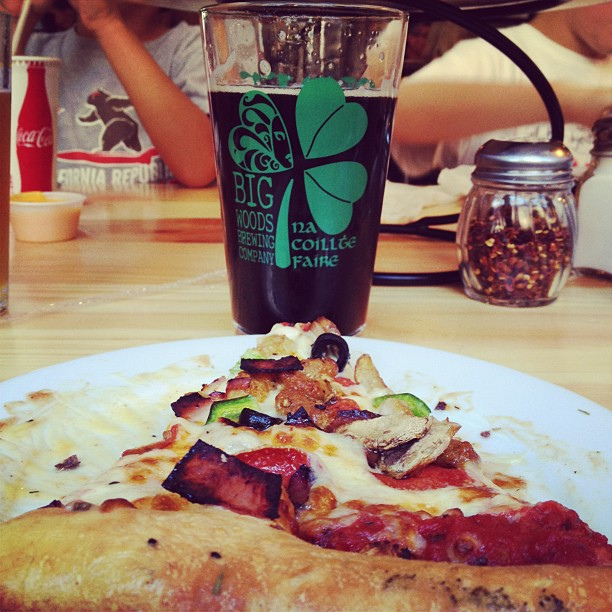

In [59]:
Image.open(image)

## Test on own image

Predicted caption: male board is over beach man shirtless rides ride wave <end>


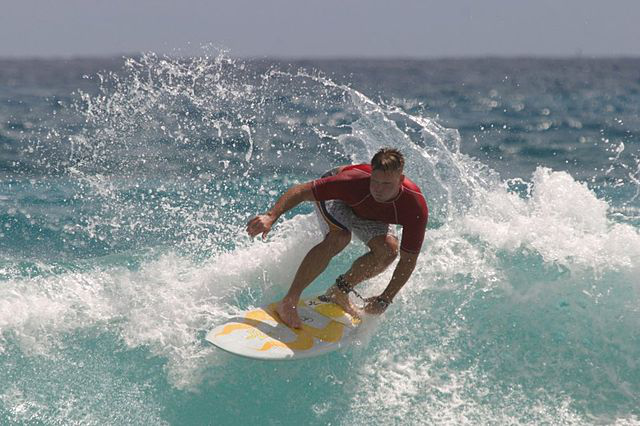

In [73]:
import os
from urllib.parse import urlparse

image_url = 'https://tensorflow.org/images/surf.jpg'
image_name = os.path.basename(urlparse(image_url).path)
image = tf.keras.utils.get_file(image_name, origin=image_url)

result = caption(image)
print ('Predicted caption:', ' '.join(result))

# opening the image
Image.open(image)